In [106]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import load_model
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
# example of defining the discriminator model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam # - Works
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import layers
import imageio
import glob
import time
from IPython import display

In [67]:
#importing the libraries
#(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()
(T_images, T_labels), (_, _) = tf.keras.datasets.mnist.load_data()
T_images = T_images.reshape(T_images.shape[0], 28, 28, 1).astype('float32')
T_images = (T_images - 127.5)/127.5 #Normalize the images
Buffer_Size = 60000
Batch_Size =256
train_dataset = tf.data.Dataset.from_tensor_slices(T_images).shuffle(Buffer_Size).batch(Batch_Size)

In [70]:
def define_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7,7, 256)
    
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding = 'same', use_bias =False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding ='same', use_bias =False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding= 'same', use_bias= False, activation ='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model
generator = define_generator_model()

In [71]:
# discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5,5), strides= (2,2), padding= 'same', input_shape= in_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
   
    model.add(Conv2D(128, (5,5), strides =(2,2), padding ='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(1, activation ='sigmoid'))
    
    #optr = Adam(lr = 0.0002, beta_1 = 0.5)
    #model.compile(loss = 'binary_crossentropy', optimizer = optr, metrics = ['accuracy'])
    return model
#model = define_discriminator()
#model.summary()
#plot_model(model, to_file= 'discriminator')
discriminator = define_discriminator()

In [83]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
def d_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def g_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [84]:
g_opt = tf.keras.optimizers.Adam(1e-4)
d_opt = tf.keras.optimizers.Adam(1e-4)

In [85]:
epoch = 50
noise_dim  = 100
ex_to_generate =16
seed = tf.random.normal([ex_to_generate, noise_dim])

In [90]:
def train_step(images):
    noise = tf.random.normal([Batch_Size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = g_loss(fake_output)
        disc_loss = d_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_opt.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_opt.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [107]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs,seed)

In [108]:
def generate_and_save_images(model, epoch, test_input):
    
    
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

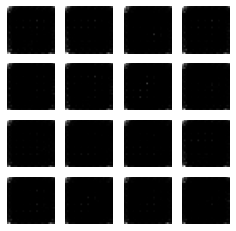

In [109]:
train(train_dataset, epoch)